# **Title:** Cross-Domain Sentiment Analysis: Evaluating Model Performance from Electronics to Cosmetics Product Reviews

## Part 03: Model Performance Comparison & Domain Shift Impact

## Import Necessary Libraries

In [ ]:
# Core Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## Connect  to drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Comparative Performance of LR, BiLSTM, and DistilBERT

In [ ]:
# Load your CSVs
results_lr = pd.read_csv('/content/drive/MyDrive/Atikuzzaman/Performance csv/logistic_regression_results.csv')
bilstm_results = pd.read_csv('/content/drive/MyDrive/Atikuzzaman/Performance csv/bilstm_results.csv')
distilbert_results = pd.read_csv('/content/drive/MyDrive/Atikuzzaman/Performance csv/distilbert_results.csv')
distilbert_results_tuned = pd.read_csv('/content/drive/MyDrive/Atikuzzaman/Performance csv/distilbert_results_tuned.csv')

# Combine all results
final_results = pd.concat([results_lr, bilstm_results, distilbert_results,distilbert_results_tuned], ignore_index=True)

# Compute F1-drop per model (in-domain F1 - cross-domain F1)
f1_drop_dict = {}
for model in final_results['Model'].unique():
    in_f1 = final_results[(final_results['Model'] == model) & (final_results['Dataset'].str.contains('In-domain'))]['F1-score'].values[0]
    cross_f1 = final_results[(final_results['Model'] == model) & (final_results['Dataset'].str.contains('Cross-domain'))]['F1-score'].values[0]
    f1_drop_dict[model] = in_f1 - cross_f1

# Add F1 Drop column for all rows per model
final_results['F1 Drop'] = final_results['Model'].map(f1_drop_dict)

# Identify best cross-domain model (highest F1-score)

best_model_idx = final_results['F1-score'].idxmax()

# Identify maximum F1 Drop (largest drop)
cross_domain_rows = final_results[final_results['Dataset'].str.contains('Cross-domain')]
max_drop_idx = cross_domain_rows['F1 Drop'].idxmax()

# Function to apply coloring and formatting
def highlight_models(row):
    styles = ['' for _ in row.index]

    # Highlight best cross-domain model metrics in green
    if row.name == best_model_idx:
        styles = ['background-color: lightgreen' if col in ['Accuracy','Precision','Recall','F1-score','F1 Drop'] else '' for col in row.index]

    # Highlight maximum F1 Drop in bold red font
    if row.name == max_drop_idx:
        styles = ['font-weight: bold; color: red;' if col == 'F1 Drop' else styles[i] for i, col in enumerate(row.index)]

    return styles

# Apply styling
styled_table = final_results.style.apply(highlight_models, axis=1)
styled_table


,Model,Dataset,Accuracy,Precision,Recall,F1-score,F1 Drop
0,Logistic Regression,Amazon Electronics (In-domain),0.751376,0.798540,0.751376,0.771689,0.012855
1,Logistic Regression,Sephora Skincare (Cross-domain),0.737771,0.786223,0.737771,0.758834,0.012855
2,BiLSTM,amazon_electronics (In-domain),0.821411,0.737512,0.821411,0.765813,0.018402
3,BiLSTM,sephora_skincare (Cross-domain),0.814555,0.722650,0.814555,0.747411,0.018402
4,DistilBERT,amazon_electronics (In-domain),0.920460,0.919196,0.920460,0.917575,0.123566
5,DistilBERT,sephora_skincare (Cross-domain),0.776464,0.818272,0.776464,0.794009,0.123566
6,DistilBERT_tuned,amazon_electronics (In-domain),0.928000,0.925480,0.928000,0.925658,0.127671
7,DistilBERT_tuned,sephora_skincare (Cross-domain),0.783000,0.816114,0.783000,0.797988,0.127671


## Final Visualization — Model Performance Comparison & Cross Domain shift

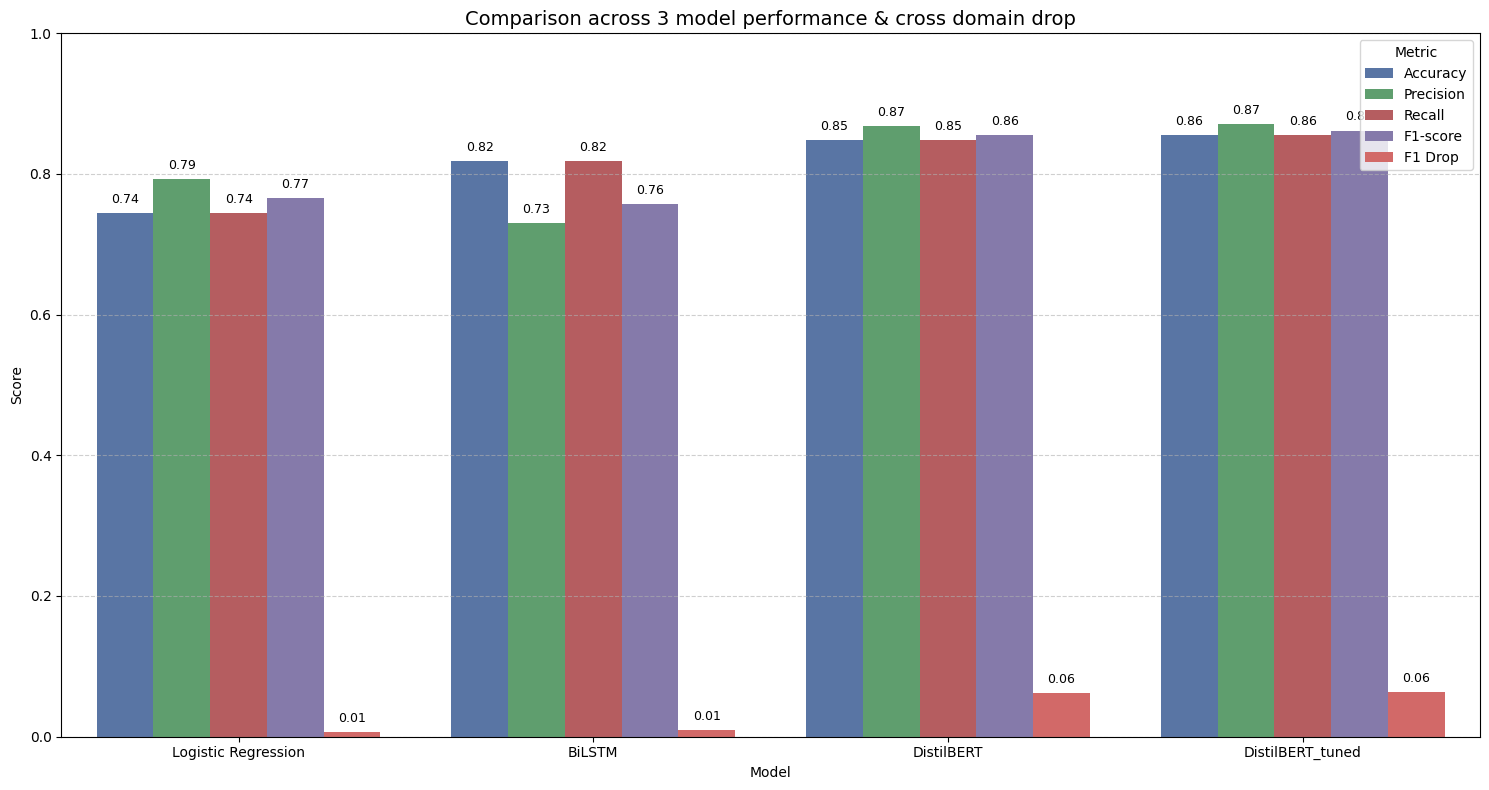

In [ ]:
# Make a copy of the final results
plot_df = final_results.copy()

# Create a new column for F1 Drop only in cross-domain rows, 0 for in-domain
plot_df['F1 Drop Plot'] = plot_df.apply(lambda row: row['F1 Drop'] if 'Cross-domain' in row['Dataset'] else 0, axis=1)

# Melt the dataframe to long format for plotting
metrics_df = plot_df.melt(
    id_vars=['Model', 'Dataset'],
    value_vars=['Accuracy', 'Precision', 'Recall', 'F1-score', 'F1 Drop Plot'],
    var_name='Metric',
    value_name='Score'
)

# Rename 'F1 Drop Plot' for clarity in legend
metrics_df['Metric'] = metrics_df['Metric'].replace({'F1 Drop Plot':'F1 Drop'})

# Set color palette (last color for F1 Drop)
palette = ['#4C72B0', '#55A868', '#C44E52', '#8172B2', '#E45756']

# Plot
plt.figure(figsize=(15,8))
sns.barplot(
    data=metrics_df,
    x='Model',
    y='Score',
    hue='Metric',
    ci=None,
    palette=palette
)

plt.title('Comparison across 3 model performance & cross domain drop', fontsize=14)
plt.ylabel('Score')
plt.ylim(0, 1)
plt.xlabel('Model')
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Annotate bars
for p in plt.gca().patches:
    height = p.get_height()
    if height > 0:
        plt.text(
            p.get_x() + p.get_width()/2.,
            height + 0.01,
            f'{height:.2f}',
            ha='center', va='bottom', fontsize=9,
            fontweight='bold' if p.get_facecolor() == (0.894, 0.341, 0.337, 1.0) else 'normal'  # bold for F1 Drop (red)
        )

plt.legend(title='Metric', loc='upper right')
plt.tight_layout()
plt.savefig('model_performance_comparison.png')
plt.show()
